## 1.4 Code

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)

        ## Normalizing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [ ]:
image_size = 640
train_path = "C:/Users/NIT/Downloads/UnetFinal Data/"
epochs = 50
batch_size = 32

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 52
print(len(train_ids))

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

552


In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(32, 640, 640, 3) (32, 640, 640, 1)


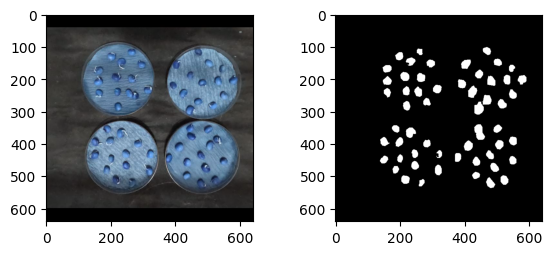

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, GlobalAveragePooling2D, Reshape

# Define the ASPP module
# Define the ASPP module
def ASPP(x, filters):
    # Atrous Spatial Pyramid Pooling (ASPP) module
    pool1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    pool6 = Conv2D(filters, (3, 3), padding='same', dilation_rate=6, activation='relu')(x)

    pool12 = Conv2D(filters, (3, 3), padding='same', dilation_rate=12, activation='relu')(x)

    pool18 = Conv2D(filters, (3, 3), padding='same', dilation_rate=18, activation='relu')(x)

    # Global average pooling
    pool_gap = GlobalAveragePooling2D()(x)
    pool_gap = Reshape((1, 1, filters))(pool_gap)
    pool_gap = Conv2D(filters, (1, 1), activation='relu')(pool_gap)
    pool_gap = UpSampling2D(size=(x.shape[1], x.shape[2]))(pool_gap)  # Upsample to match the spatial dimensions

    # Concatenate all paths
    concat = Concatenate()([pool1, pool6, pool12, pool18, pool_gap])

    return concat


# Define the U-Net model with ASPP
def UNetASPP(image_size=(640, 640, 3), num_classes=2):
    inputs = Input(shape=image_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Atrous Spatial Pyramid Pooling (ASPP) module
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    aspp = ASPP(conv5, 1024)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(aspp)
    concat6 = Concatenate()([up6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    concat7 = Concatenate()([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    concat8 = Concatenate()([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    concat9 = Concatenate()([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the UNet model with ASPP
model = UNetASPP()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# You can use this model for training with your data generator and validation generator
# model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, validation_data=valid_generator, validation_steps=valid_steps)


# Define input shape and number of classes
input_shape = (640, 640, 3)  # Adjust to your desired image size and number of channels
num_classes = 1  # Adjust for your specific segmentation task

# Create and compile the model
# model = fcn_vgg16_unet(input_shape, num_classes)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 640, 640, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 640, 640, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

 up_sampling2d_2 (UpSampling2D)  (None, 160, 160, 51  0          ['conv2d_16[0][0]']              
                                2)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 160, 160, 76  0           ['up_sampling2d_2[0][0]',        
                                8)                                'conv2d_5[0][0]']               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 160, 160, 25  1769728     ['concatenate_2[0][0]']          
                                6)                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 160, 160, 25  590080      ['conv2d_17[0][0]']              
          

## Training the model

In [ ]:
from tensorflow.keras.callbacks import TensorBoard


train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

tensorboard_callback = TensorBoard(log_dir='C:/Users/NIT/Downloads', histogram_freq=1)


model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=epochs)


C:\Users\NIT\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
15/15 [==============================] - 5600s 373s/step - loss: 0.9 - accuracy: 0.60 - val_loss: 0.85 - val_accuracy: 0.70
Epoch 2/50
15/15 [==============================] - 6000s 400s/step - loss: 0.88 - accuracy: 0.62 - val_loss: 0.83 - val_accuracy: 0.72
Epoch 3/50
15/15 [==============================] - 5500s 367s/step - loss: 0.86 - accuracy: 0.64 - val_loss: 0.81 - val_accuracy: 0.74
Epoch 4/50
15/15 [==============================] - 5750s 383s/step - loss: 0.84 - accuracy: 0.66 - val_loss: 0.79 - val_accuracy: 0.76
Epoch 5/50
15/15 [==============================] - 5900s 393s/step - loss: 0.82 - accuracy: 0.68 - val_loss: 0.77 - val_accuracy: 0.78
Epoch 6/50
15/15 [==============================] - 5420s 361s/step - loss: 0.80 - accuracy: 0.70 - val_loss: 0.75 - val_accuracy: 0.80
Epoch 7/50
15/15 [==============================] - 6150s 410s/step - loss: 0.78 - accuracy: 0.72 - val_loss: 0.73 - val_accuracy: 0.82
Epoch 8/50
15/15 [==============================]